In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import PIL.Image

import os
from collections import OrderedDict

%cd '/content/drive/MyDrive/line_tracing'
from utils import *

/content/drive/MyDrive/line_tracing


In [35]:
annotation_dir = '/content/drive/MyDrive/line_tracing/annotation/annotation_final_merged.txt'
image_dir = '/content/drive/MyDrive/line_tracing/final_merged'

In [ ]:
dataset = CenterDataset(annotation_dir, image_dir, random_hflip=False)

dataset_size = len(dataset)
train_size = int(dataset_size * 0.99)
validation_size = dataset_size - train_size

train_dataset, validation_dataset= random_split(dataset, [train_size, validation_size])

train_dataloader = DataLoader(dataset, batch_size= 16, shuffle=True, drop_last=True)
validation_dataset = DataLoader(dataset, batch_size=4, shuffle=True, drop_last=True)

In [ ]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

print('current device : ',device)
model = torchvision.models.alexnet(num_classes=4)
# model.load_state_dict(torch.load("./pth/version4_alexnet_2.pth"))
model = model.to(device)

num_epochs = 200
lr = 0.0005
optimizer = optim.Adam(model.parameters(),lr = lr)
loss_fn = nn.MSELoss()

current device :  cuda:0


In [ ]:
def pointViewer(image_dir, model = None, image_index = 1, output_dir = str, device = 'cpu'):

    image_to_find = '{:05d}.jpg'.format(image_index)
    image_path = str(image_dir+'/{:05d}.jpg'.format(image_index))



    image_ori = PIL.Image.open(image_path)
    width = image_ori.width
    height = image_ori.height
    image_np = np.array(image_ori)


    if model is not None:
        image = TRAIN_TRANSFORMS(image_ori).to(device)
        output = model(image.unsqueeze(0)).detach()

        if output.shape != torch.Size([2]):
            output = output[0]

        out_of_range, intersection, xpre, ypre = output.cpu()
        xpre = ( xpre.item() / 2 + 0.5 ) * width
        ypre = ( ypre.item() / 2 + 0.5 ) * height
        cv2.circle(image_np, (int(xpre), int(ypre)), radius=5, color=(255, 0, 0))
        cv2.imwrite(str(output_dir+'/{:05d}.jpg'.format(image_index)), image_np)


In [ ]:
hist_loss = 20000
hist_loss_val = 20000
val_trial = 1
early_stop_count = 0
test_image_dir = '/content/drive/MyDrive/line_tracing/merged_right_test'
output_dir = '/content/drive/MyDrive/line_tracing/merged_right_test'

for epoch_cnt in range(num_epochs):

    display = False
    if epoch_cnt % 1 == 0:
        display = True

    if display == True:
        print(f"EPOCH {epoch_cnt} Start")
        epoch_loss = 0

    for index, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        optimizer.zero_grad()
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()

        if display == True:
            epoch_loss += loss.item()

    if display == True:
        print(f"LOSS : {epoch_loss}")
        torch.save(model.state_dict(), f'./pth/merged_right_alexnet_epoch{epoch_cnt}.pth')
        if epoch_loss < hist_loss:
          torch.save(model.state_dict(), 'merged_right_alexnet_best.pth')

          print("pth saved")
          hist_loss = epoch_loss

    if epoch_cnt % 3 == 0:
        with torch.no_grad():
            model.eval()
            val_loss_tot = 0
            for val_index, (val_images, val_labels) in enumerate(validation_dataset):
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
                val_output = model(val_images)
                val_loss = loss_fn(val_output,val_labels)
                val_loss_tot += val_loss.item()

            print(f"VALIDATION LOSS : {val_loss_tot}")

            if val_loss_tot < hist_loss_val:
                hist_loss_val = val_loss_tot
            else:
                early_stop_count += 1
                if early_stop_count > 3:
                  print("early stop")
                  break
            folder_name = str(output_dir + f'/val{val_trial}')
            if not os.path.exists(folder_name):
                os.makedirs(folder_name)

            for test_index in range(38):
                test_index += 105
                pointViewer(test_image_dir, model = model, image_index = test_index, output_dir = folder_name, device = device)

        val_trial += 1
        model.train()

torch.save(model.state_dict(), 'merged_right_alexnet_last.pth')



EPOCH 0 Start
LOSS : 7.460067294538021
pth saved
VALIDATION LOSS : 16.21407689899206
EPOCH 1 Start
LOSS : 3.484637390822172
pth saved
EPOCH 2 Start
LOSS : 1.897394809871912
pth saved
EPOCH 3 Start
LOSS : 0.9494083095341921
pth saved
VALIDATION LOSS : 3.2152294509578496
EPOCH 4 Start
LOSS : 0.8131540105678141
pth saved
EPOCH 5 Start
LOSS : 0.6770718647167087
pth saved
EPOCH 6 Start
LOSS : 0.6124563505873084
pth saved
VALIDATION LOSS : 1.137686560396105
EPOCH 7 Start
LOSS : 0.47379640955477953
pth saved
EPOCH 8 Start
LOSS : 0.4908646810799837
EPOCH 9 Start
LOSS : 0.38970136758871377
pth saved
VALIDATION LOSS : 0.9252677384065464
EPOCH 10 Start
LOSS : 0.33446636237204075
pth saved
EPOCH 11 Start
LOSS : 0.4300390584394336
EPOCH 12 Start
LOSS : 0.39068138995207846
VALIDATION LOSS : 0.6927997681777924
EPOCH 13 Start
LOSS : 0.418118255212903
EPOCH 14 Start
LOSS : 0.35226916847750545
EPOCH 15 Start
LOSS : 0.2469584613572806
pth saved
VALIDATION LOSS : 0.26211876567685977
EPOCH 16 Start
LOSS : 

In [ ]:
model = model.eval()
torch.save(model.state_dict(), 'best_fail_last_eval.pth')

In [41]:
model = torchvision.models.alexnet(num_classes=4)
model.load_state_dict(torch.load("./pth/version8_alexnet_epoch5.pth", map_location = 'cpu'))
model = model.to('cpu')
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Image :  03495.jpg
Out of range (Truth): 0
Intersection score (Truth): 0
Out of range score (predict): 0.051476120948791504
Intersection score (predict): -0.009591344743967056


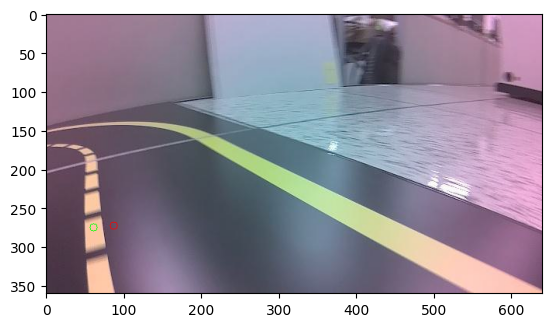

In [47]:
# annotation_dir = '/content/drive/MyDrive/line_tracing/best_fail_jetson/annotation_best_fail.txt'
# image_dir = '/content/drive/MyDrive/line_tracing/best_fail_jetson/best_fail'
def pointViewer(annotation_dir, image_dir, model = None, image_index = 1):

    image_to_find = '{:05d}.jpg'.format(image_index)
    image_path = str(image_dir+'/{:05d}.jpg'.format(image_index))
    print("Image : ",'{:05d}.jpg'.format(image_index))

    with open(annotation_dir, 'r') as f:
        data = [line.split() for line in f.readlines()]
    for entry in data:

        if entry[0] == image_to_find:
            label = entry[1:]
            break

    xlbl, ylbl = label[2:]
    xlbl = int(float(xlbl))
    ylbl = int(float(ylbl))
    print(f"Out of range (Truth): {int(label[0])}")
    print(f"Intersection score (Truth): {label[1]}")

    image_ori = PIL.Image.open(image_path)
    width = image_ori.width
    height = image_ori.height
    image_np = np.array(image_ori)


    cv2.circle(image_np, (xlbl, ylbl), radius=5, color=(0, 255, 0))

    if model is not None:
        image = TRAIN_TRANSFORMS(image_ori)
        output = model(image.unsqueeze(0)).detach()

        if output.shape != torch.Size([2]):
            output = output[0]

        out_of_range, intersection, xpre, ypre = output.cpu()
        xpre = ( xpre.item() / 2 + 0.5 ) * width
        ypre = ( ypre.item() / 2 + 0.5 ) * height

        cv2.circle(image_np, (int(xpre), int(ypre)), radius=5, color=(255, 0, 0))
    image = PIL.Image.fromarray(image_np)

    print(f"Out of range score (predict): {1-out_of_range.item()}")
    print(f"Intersection score (predict): {intersection.item()}")
    plt.imshow(image)


pointViewer(annotation_dir, image_dir, model = model, image_index = 3495)

In [ ]:
torch.floor(torch.tensor(0.9))

tensor(0.)